# Let's give gymsnake a brain

<img src="smartsnake.jpg" alt="drawing" width="800"/>

Neuroevolution worked very well for Cartpole. Let's therefore also apply it to gymsnake. Why gymsnake is a harder problem to tackle than Cartpole?

Start with 'Neuroevolution for Gymnasium Cartpole' as a basis and transform it in such a way that it can be used for gymsnake. To do this, the following code changes need to be performed:
* Load the gymsnake environment instead of the Cartpole environment
* Use a snake grid of 4x4, otherwise learning takes a lot of time. On the other hand, with a too small grid, the luck factor becomes important, which impedes learning
* Adapt the number of input neurons of the NN to the size of the observation of the gymsnake environment
* Adapt the number of output neurons of the NN to the number of actions of the gymsnake environment
* Cart pole episodes can be very long, easily 100000 steps. Gymsnake episodes typically do not exceed 400 steps. Adapt the `max_episode_length` to 400. Otherwise, when the snake is in an endless loop, we're waiting for nothing, as the snake is not learning
* The `feed_forward()` method expects a 1D observation space, whereas as the observation space of gymsnake is 2D. Therefore, `flatten()` the observation space from 2D to 1D when passing the observation to the `step()` method: 

  `observation, reward, terminated, truncated, _ = env.step(self.feed_forward(np.array(observation).flatten()))`

* Now the hard part, the hyperparameter values. These should be determined by means of trial & error. To save you time, the following hyperparameter values should show learning behavior; several tries might be needed:
  * an NN with two hidden layers of each 64 neurons (Cartpole had only one hidden layer)
  * population_size=1000
  * generations=200
  * n_episodes=1 (food is in same square at start, so no need to play multiple episodes)
  * mutation_variance=0.2
  
You might need to run the program several times, because sometimes, the snake does not manage to find the food and therefore does not learn at all (the well-known bootstrapping problem). In these cases, the program finishes in 10 seconds. When learning occurs, the program takes about 5-10 minutes to finish on a reasonably fast laptop, using the hyperparameter values mentioned above.

Once you've observed learning behavior (e.g. `Generation: 155 | Highest Reward: 8.0 | Average Reward: 0.4`) with the settings above, you can start to experiment to improve the performance. Two options are obvious candidates for experimentation:
* Play with the hyperparameters
* Currently the genetic algorithm only uses mutation to evolve. As form of elitism, only the best network is saved. No crossover is done. Play with the various ways of evolution and determine the effect on learning behavior.

In [5]:
import numpy as np
import gymnasium as gym
from time import time
import pickle
import gymsnake

def relu(x):
    '''
    activation function
    '''
    return np.where(x > 0, x, 0)

def softmax(x):
    '''
    convert the output to probabilities by using softmax
    '''
    x = np.exp(x - np.max(x))
    x[x == 0] = 1e-15  # to avoid division by 0
    return np.array(x / x.sum())

gym register called for snake-v1!


In [6]:
class NeuralNet:
    '''
    neural network class that interacts with an Gymnasium environment
    '''
    
    def __init__(self, n_units=None, copy_network=None, var=0.02):
        if copy_network is None:  # create new NN
            self.n_units = n_units
            weights = []
            biases = []
            # initialize weights and biases
            for i in range(len(n_units)-1):
                weights.append(np.random.normal(loc=0, scale=1, size=(n_units[i], n_units[i+1])))
                biases.append(np.zeros(n_units[i+1]))
            # put weights and biases in a dictionary
            self.params = {'weights': weights,'biases': biases}
        else:  # copy the NN
            self.n_units = copy_network.n_units
            weights = []
            biases = []
            for layer_weights in copy_network.params['weights']:
                weights.append(layer_weights)
            for layer_biases in copy_network.params['biases']:
                biases.append(layer_biases)
            self.params = {'weights': weights, 'biases': biases}
            # perform mutation of weights and biases
            self.params['weights'] = [x+np.random.normal(loc=0, scale=var, size=x.shape) for x in self.params['weights']]
            self.params['biases'] = [x+np.random.normal(loc=0, scale=var, size=x.shape) for x in self.params['biases']]
            
    def feed_forward(self, X):
        weights = self.params['weights']
        biases = self.params['biases']
        # first propagate inputs
        a = relu((X@weights[0]) + biases[0])
        # then propagate through every other layer
        for layer in range(1, len(weights)):
            a = relu((a@weights[layer]) + biases[layer])
        probs = softmax(a)
        return np.argmax(probs)
        
    def evaluate(self, n_episodes, max_episode_length, render_env):
        '''
        Evaluates the performance of the NN by playing plays `n_episodes` of the Cartpole game. 
        Actions are predicted by the NN. 
        Evaluate() returns the mean reward of the `n_episodes` games to obtain a reliable evaluation.
        
        max_episode_length: limits the max length of an episode to max_episode_length steps
        render_env: boolean to turn on/off rendering of the environment
        '''
        env = gym.make('snake-v1', grid_size =(4, 4), render_mode="human")
        env._max_episode_steps=1e20  # do not use max episode length in Gymnasium TimeLimit wrapper
            
        rewards = []
        for _ in range(n_episodes):
            observation, info = env.reset()
            episode_reward = 0
            for _ in range(max_episode_length):
                if render_env:
                    env.render()
                observation, reward, terminated, truncated, _ = env.step(self.feed_forward(np.array(observation).flatten()))
                assert not truncated, 'episode truncated by Gymnasium' 
                done = terminated or truncated
                episode_reward += reward
                if done:
                    rewards.append(episode_reward)
                    break
        env.close()

        if len(rewards) == 0:
            return 0
        else:
            return np.array(rewards).mean()

C:\Users\Justin\MachineLearningPlayground\ML4\Challenge\gymsnake1.0\src\gymsnake\envs\snake_env.py:201: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


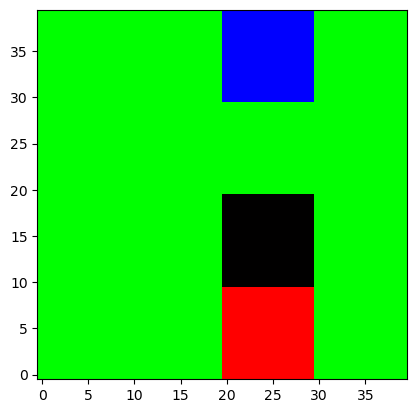

-1.0

In [7]:
# try a random network
random_network = NeuralNet(n_units=(16, 64, 64, 4))
random_network.evaluate(n_episodes=1, max_episode_length=400, render_env=True)

In [8]:
class GeneticAlg():
    '''
    handles the population of NNs    
    '''
    
    def __init__(self, architecture, population_size, generations, mutation_variance, n_episodes, max_episode_length, 
                 render_env, verbose, print_every):
        # create list of NNs
        self.networks = [NeuralNet(architecture) for _ in range(population_size)]
        self.best_network = NeuralNet(architecture)
        self.population_size = population_size
        self.generations = generations
        self.mutation_variance = mutation_variance
        self.fitness = []
        self.n_episodes = n_episodes
        self.max_episode_length = max_episode_length
        self.render_env = render_env
        self.verbose = verbose
        self.print_every = print_every
        
    def fit(self):
        '''
        For every generation the following steps are performed:
        - the performance of every member of the population is evaluated
        - the best network is selected and its score is saved
        - children are created that are mutations of the best network
        - the best network survives into the next generation and children are added to the new generation
        '''
        for i in range(self.generations):
            rewards = np.array([x.evaluate(self.n_episodes, self.max_episode_length, self.render_env) 
                                for x in self.networks])
            # select the best NN
            best_network = np.argmax(rewards)
            # track best score per generation
            self.fitness.append(np.max(rewards))
            # create child NNs that are mutations of the best NN
            new_networks = [NeuralNet(copy_network=self.networks[best_network], var=self.mutation_variance) 
                            for _ in range(self.population_size-1)]
            # only the best NN survives + add the children
            self.networks = [self.networks[best_network]] + new_networks
            if self.verbose is True and (i % self.print_every == 0 or i == 0):
                print(f'Generation: {i+1} | Highest Reward: {rewards.max().round(1)} | Average Reward: '
                      f'{rewards.mean().round(1)}')
        # save the best network for playing
        self.best_network = self.networks[best_network]
        with open('best_NN.pkl', 'wb') as f:
            pickle.dump(self.best_network, f)

In [11]:
# train a population of NNs
start_time = time()
# hyperparameter values determined by means of trial and error!!
genetic_population = GeneticAlg(architecture=(16, 64, 64, 4),
                         population_size=1000, 
                         generations=200,
                         mutation_variance=0.2,
                         n_episodes=1, 
                         max_episode_length=10000,
                         render_env=False,
                         verbose=True,
                         print_every=1)
genetic_population.fit()
print(f'Finished in {round(time() - start_time, 3)} seconds')

Generation: 1 | Highest Reward: 0.0 | Average Reward: -1.0
Generation: 2 | Highest Reward: 1.0 | Average Reward: -0.5
Generation: 3 | Highest Reward: 1.0 | Average Reward: -0.1
Generation: 4 | Highest Reward: 1.0 | Average Reward: -0.2
Generation: 5 | Highest Reward: 1.0 | Average Reward: -0.3
Generation: 6 | Highest Reward: 1.0 | Average Reward: -0.4
Generation: 7 | Highest Reward: 1.0 | Average Reward: -0.4
Generation: 8 | Highest Reward: 1.0 | Average Reward: -0.5
Generation: 9 | Highest Reward: 1.0 | Average Reward: -0.2
Generation: 10 | Highest Reward: 1.0 | Average Reward: -0.5
Generation: 11 | Highest Reward: 1.0 | Average Reward: -0.3
Generation: 12 | Highest Reward: 1.0 | Average Reward: -0.2
Generation: 13 | Highest Reward: 1.0 | Average Reward: -0.3
Generation: 14 | Highest Reward: 1.0 | Average Reward: -0.3
Generation: 15 | Highest Reward: 1.0 | Average Reward: -0.7
Generation: 16 | Highest Reward: 1.0 | Average Reward: -0.4
Generation: 17 | Highest Reward: 1.0 | Average Re

In [12]:
# load best network from disk
with open('best_NN.pkl', 'rb') as f:
    genetic_population.best_network = pickle.load(f)

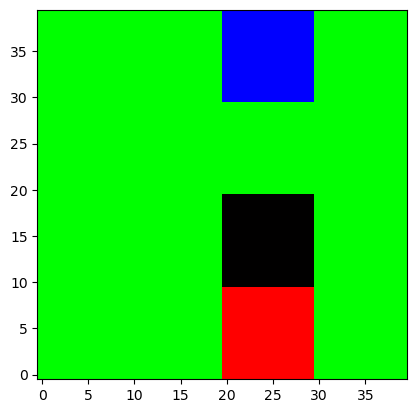

-1.0

In [13]:
# play an episode using the best network
genetic_population.best_network.evaluate(n_episodes=1, max_episode_length=int(1e10), render_env=True)